In [21]:
import pandas as pd
import numpy
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df_anime = pd.read_csv('top_and_bottom_anime.csv')
df_anime = df_anime.drop(columns='Id')
df_anime = df_anime.drop(columns='Rating')
df_anime = df_anime.drop(columns='Demographic')
df_anime = df_anime.drop(columns='VAs')

new = pd.DataFrame()
le = preprocessing.LabelEncoder()
for i in range(df_anime.shape[1]):
    temp = df_anime.iloc[:,i].values.tolist()
    temp = le.fit_transform(temp)
    new[df_anime.columns[i]] = temp

df_anime_y = pd.read_csv('anime_matrix_true.csv')
rows = df_anime_y[['Id']].copy()


In [22]:
#this sets up df_predictions with the same rows as this train/test split
x = new
y = rows
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

#create cross training split for building the models
X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(x_train, y_train, test_size=0.2, random_state=420)
df_predictions = y_cross_test.copy()

In [23]:
#Same spits are performed again to create df_true to check accuracy 
#create main split for training and testing
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(df_anime_y, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
A_cross_train, A_cross_test, b_cross_train, b_cross_test = train_test_split(A_train, b_train, test_size=0.2, random_state=420)

df_true = A_cross_test.copy()

In [24]:
columns = df_anime_y.columns
predictions = []

avg = []
for i in tqdm(range(1,len(columns))):   #skip first item b/c it's anime Id
    x = new
    y = df_anime_y[columns[i]]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)
    
    #create cross training split for building the models
    X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(x_train, y_train, test_size=0.2, random_state=420)

    adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
    adaboost.fit(X_cross_train,y_cross_train)
    avg.append(adaboost.score(X_cross_test,y_cross_test))
    predictions.append(list(adaboost.predict(X_cross_test)))

# result

100%|██████████| 9028/9028 [13:30<00:00, 11.14it/s]


In [ ]:
columns = df_true.columns[1:]
predictions = []

avg = []

x = new
y = df_true[columns[i]]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

#create cross training split for building the models
X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(x_train, y_train, test_size=0.2, random_state=420)

adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_cross_train,y_cross_train)
avg.append(adaboost.score(X_cross_test,y_cross_test))
predictions.append(list(adaboost.predict(X_cross_test)))

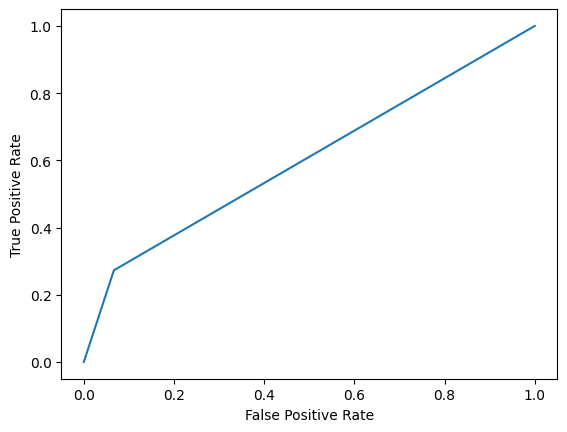

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
#define metrics

y_pred_proba = adaboost.predict(x_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot([0,0.06666667,1],[0,0.27272727,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
import pickle

file = open('predictions.p', 'wb')
pickle.dump(predictions, file)

In [4]:
import pickle

file = open('predictions.p', 'rb')
predictions = pickle.load(file)

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
for i in tqdm(range(1,len(columns))):               #skip first item b/c that is anime id
    df_predictions[columns[i]] = predictions[i-1]   #predictions is off by one b/c it does not have anime id

outputdf = df_predictions.copy()
outputdf.to_csv(f'predictions_matrix_adaboost_drop_va.csv', index=False)

100%|██████████| 9028/9028 [00:06<00:00, 1327.78it/s]


In [111]:
import pickle

# open a file, where you ant to store the data
file = open('adaboost.model', 'wb')

# dump information to that file
pickle.dump(adaboost, file)

# close the file
file.close()

In [4]:
#creates true_values for only the shows included in this train/test split

df_true = pd.read_csv('anime_matrix_true.csv')
values = df_true.values
anime_ids = list(df_predictions['Id'])
true_values = []
for anime in anime_ids:
    for j in range(len(values)):
        if anime in values[j]:
            true_values.append(values[j])

true_values = numpy.array([numpy.array(xi) for xi in true_values])

In [26]:
#caluclate accuracy
correct = 0
prediction_matrix = pd.read_csv('predictions_matrix_adaboost_drop_va.csv')
pred_values = prediction_matrix.values
true_values = df_true.values
predict_watch = 0
true_watch = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
null = 0

num_row = len(pred_values)
num_col = len(pred_values[0])
for i in tqdm(range(num_row)):
    for j in range(1,num_col):          #first item is the anime id, so we skip it
        if pred_values[i,j] == true_values[i,j]:
            correct += 1
        if pred_values[i,j] == 1:
            predict_watch += 1
            if true_values[i,j] == 1:
                true_pos += 1
                true_watch += 1
            else:
                false_pos += 1

        if pred_values[i,j] == 0:
            if true_values[i,j] == 0:
                true_neg += 1
            else:
                false_neg += 1
                true_watch += 1

        if 0 == true_values[i,j]:
            null += 1
        

#subtracting 1 from column length b/c the first item is the anime id
percent = (correct / ((num_row) * (num_col-1))) * 100
total = (num_row) * (num_col-1)
print(f'Total predictions: {total}')
print(f'Correct predictions: {correct}')

print(f'Predicted watch: {predict_watch}')
print(f'True watched: {true_watch}')
print(f'True positive: {true_pos}')
print(f'True negative: {true_neg}')
print(f'False positive: {false_pos}')
print(f'False negative: {false_neg}')
print(f'Null Error Rate: {(null / total)*100: .2f}')
print(f'Percent correct: {percent: .2f}%')
print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

100%|██████████| 89/89 [00:00<00:00, 143.88it/s]

Total predictions: 803492
Correct predictions: 662519
Predicted watch: 127504
True watched: 144439
True positive: 65485
True negative: 597034
False positive: 62019
False negative: 78954
Null Error Rate:  82.02
Percent correct:  82.45%
Precision:  0.51
Recall:  0.45


C:\Users\Tenkawa PC\AppData\Local\Temp\ipykernel_16924\678633288.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

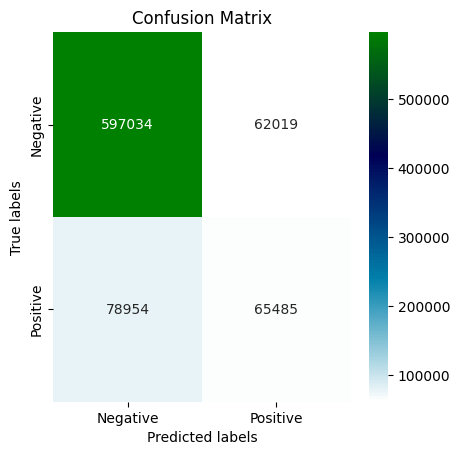

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

#have to convert true_values and pred_values from matrix to list
y_true = []
y_pred = []
for i in range(len(true_values)):
    y_true += list(true_values[i][1:])
    y_pred += list(pred_values[i][1:])

cm = confusion_matrix(y_true,y_pred)
plt.matshow(cm)

   

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='ocean_r');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f'Accuray: {accuracy_score(y_true, y_pred):.2f}')
print(f'Precision: {precision_score(y_true, y_pred):.2f}')
print(f'Recall: {recall_score(y_true, y_pred):.2f}')
print(f'F1 score: {f1_score(y_true, y_pred):.2f}')

Accuray: 0.82
Precision: 0.51
Recall: 0.45
F1 score: 0.48
